<a href="https://colab.research.google.com/github/RajuKumar21/GenzEducateWing/blob/main/PROJECT02_RAJU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics opencv-python matplotlib pillow numpy torch torchvision
!pip install roboflow yt-dlp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 36.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

from ultralytics import YOLO
import torch


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
class YOLOObjectDetector:
    def __init__(self, model_size='n'):
        """
        Initialize YOLO detector
        model_size: 'n', 's', 'm', 'l', 'x' (nano to extra-large)
        """
        self.model_size = model_size
        self.model = None
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"✅ Using device: {self.device}")

        self.setup_directories()

    def setup_directories(self):
        """Create necessary folders"""
        self.dirs = {
            'data': Path('data'),
            'models': Path('models'),
            'results': Path('results'),
            'datasets': Path('datasets')
        }
        for p in self.dirs.values():
            p.mkdir(parents=True, exist_ok=True)

    def load_model(self, custom_weights=None):
        """Load YOLOv8 model"""
        print("\n📦 Loading YOLO model...")
        if custom_weights and os.path.exists(custom_weights):
            self.model = YOLO(custom_weights)
            print(f"✅ Custom weights loaded: {custom_weights}")
        else:
            model_name = f"yolov8{self.model_size}.pt"
            self.model = YOLO(model_name)
            print(f"✅ Pre-trained model loaded: {model_name}")
        return self.model


In [4]:
    def prepare_coco_subset(self, num_images=100):
        print(f"Preparing COCO subset with {num_images} images...")
        dataset_yaml = f"""
path: {self.dirs['datasets'].absolute()}
train: images/train
val: images/val

nc: 80
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']
"""
        dataset_path = self.dirs['datasets'] / 'coco_subset.yaml'
        with open(dataset_path, 'w') as f:
            f.write(dataset_yaml)
        print(f"Dataset configuration saved to: {dataset_path}")
        return str(dataset_path)

    def train_model(self, dataset_yaml, epochs=10, img_size=640):
        print("Starting model training...")
        print(f"  - Model size: {self.model_size}")
        print(f"  - Epochs: {epochs}")
        print(f"  - Image size: {img_size}")
        if self.model is None:
            self.load_model()
        results = self.model.train(
            data=dataset_yaml,
            epochs=epochs,
            imgsz=img_size,
            batch=16,
            device=self.device,
            workers=4,
            cache=True,
            amp=True,
            save_period=5,
            project=str(self.dirs['results']),
            name='yolo_training'
        )
        print("Training completed!")
        return results


In [5]:
    def detect_objects(self, source, conf_threshold=0.5, save_results=True):
        if self.model is None:
            self.load_model()
        print(f"Detecting objects in: {source}")
        results = self.model(
            source,
            conf=conf_threshold,
            device=self.device,
            save=save_results,
            project=str(self.dirs['results']),
            name='detections'
        )
        return results

    def evaluate_model(self, dataset_yaml):
        if self.model is None:
            self.load_model()
        print("Evaluating model performance...")
        metrics = self.model.val(
            data=dataset_yaml,
            device=self.device,
            project=str(self.dirs['results']),
            name='evaluation'
        )
        print("\n📊 Evaluation Results:")
        print(f"mAP@0.5: {metrics.box.map50:.4f}")
        print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
        print(f"Precision: {metrics.box.mp:.4f}")
        print(f"Recall: {metrics.box.mr:.4f}")
        return metrics


In [6]:
    def detect_webcam_colab(self, conf_threshold=0.5):
        try:
            from IPython.display import display, Javascript
            from google.colab.output import eval_js
            from base64 import b64decode
            import PIL.Image as PILImage
            import io

            if self.model is None:
                self.load_model()

            def take_photo(filename='photo.jpg', quality=0.8):
                js = Javascript('''
                async function takePhoto(quality) {
                    const div = document.createElement('div');
                    const capture = document.createElement('button');
                    capture.textContent = 'Capture Photo';
                    div.appendChild(capture);

                    const video = document.createElement('video');
                    video.style.display = 'block';
                    const stream = await navigator.mediaDevices.getUserMedia({video: true});

                    document.body.appendChild(div);
                    div.appendChild(video);
                    video.srcObject = stream;
                    await video.play();

                    google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

                    await new Promise((resolve) => {
                        capture.onclick = resolve;
                    });

                    const canvas = document.createElement('canvas');
                    canvas.width = video.videoWidth;
                    canvas.height = video.videoHeight;
                    canvas.getContext('2d').drawImage(video, 0, 0);
                    stream.getVideoTracks()[0].stop();
                    div.remove();
                    return canvas.toDataURL('image/jpeg', quality);
                }
                ''')
                display(js)
                data = eval_js('takePhoto({})'.format(quality))
                return data

            print("📸 Click 'Capture Photo' to take a photo for detection")
            image_data = take_photo()
            image_data = image_data.split(',')[1]
            image_bytes = b64decode(image_data)
            image = PILImage.open(io.BytesIO(image_bytes))

            image_path = self.dirs['data'] / 'webcam_capture.jpg'
            image.save(image_path)

            results = self.detect_objects(str(image_path), conf_threshold)
            self.display_results_colab(results)
            return results

        except ImportError:
            print("❌ This function requires Google Colab environment")
            return None

    def detect_uploaded_image(self, conf_threshold=0.5):
        try:
            from google.colab import files
            from PIL import Image as PILImage

            if self.model is None:
                self.load_model()

            print("📁 Please upload an image file...")
            uploaded = files.upload()
            results_list = []

            for filename in uploaded.keys():
                print(f"Processing: {filename}")
                image_path = self.dirs['data'] / filename
                with open(image_path, 'wb') as f:
                    f.write(uploaded[filename])

                results = self.detect_objects(str(image_path), conf_threshold)
                results_list.extend(results)

            self.display_results_colab(results_list)
            return results_list

        except ImportError:
            print("❌ This function requires Google Colab environment")
            return None

    def detect_youtube_video(self, youtube_url, conf_threshold=0.5):
        try:
            import yt_dlp

            if self.model is None:
                self.load_model()

            print(f"📺 Downloading video from: {youtube_url}")
            ydl_opts = {
                'format': 'best[height<=480]',
                'outtmpl': str(self.dirs['data'] / 'youtube_video.%(ext)s')
            }

            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([youtube_url])

            video_files = list(self.dirs['data'].glob('youtube_video.*'))
            if not video_files:
                print("❌ Failed to download video")
                return None

            video_path = video_files[0]
            print(f"✅ Video downloaded: {video_path}")
            results = self.detect_objects(str(video_path), conf_threshold)
            return results

        except ImportError:
            print("❌ Please install yt-dlp: pip install yt-dlp")
            return None

    def display_results_colab(self, results):
        try:
            if not results:
                print("No results to display")
                return

            for i, result in enumerate(results):
                img_array = result.plot()
                plt.figure(figsize=(12, 8))
                plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title(f'YOLO Detection Results - Image {i+1}')
                plt.tight_layout()
                plt.show()

                if hasattr(result, 'boxes') and result.boxes is not None:
                    print(f"\n📊 Detections in Image {i+1}:")
                    for j, box in enumerate(result.boxes):
                        class_id = int(box.cls)
                        confidence = float(box.conf)
                        class_name = result.names[class_id]
                        print(f"  {j+1}. {class_name}: {confidence:.2f}")

        except Exception as e:
            print(f"❌ Error displaying results: {e}")


In [7]:
def create_sample_images():
    """Create sample images for testing if no images available"""
    sample_dir = Path('sample_images')
    sample_dir.mkdir(exist_ok=True)

    print("Creating sample test images...")
    for i in range(3):
        img = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
        cv2.rectangle(img, (50 + i * 100, 50), (150 + i * 100, 150), (0, 255, 0), -1)
        cv2.circle(img, (300 + i * 50, 300), 50, (255, 0, 0), -1)
        cv2.imwrite(str(sample_dir / f'test_image_{i+1}.jpg'), img)

    print(f"Sample images created in: {sample_dir}")
    return sample_dir

def main():
    print("🚀 YOLO Object Detection Project - Optimized for Speed")
    print("=" * 60)

    # Check Colab or Local
    try:
        import google.colab
        print("🌐 Detected Google Colab environment")
        return colab_demo()
    except ImportError:
        print("💻 Detected Local environment")

    detector = YOLOObjectDetector(model_size='n')
    detector.load_model()
    sample_dir = create_sample_images()
    results = detector.detect_objects(str(sample_dir), conf_threshold=0.3)

    test_image = sample_dir / 'test_image_1.jpg'
    avg_time, fps = detector.benchmark_speed(str(test_image), num_runs=50)

    print("\n✅ Project completed successfully!")
    print(f"📁 Results saved in: {detector.dirs['results']}")
    return detector

def colab_demo():
    print("🚀 YOLO Project - Google Colab Optimized Version")
    print("=" * 50)

    detector = YOLOObjectDetector(model_size='n')
    detector.load_model()
    sample_dir = create_sample_images()
    print("\n📸 Running detection on sample images...")
    results = detector.detect_objects(str(sample_dir))
    detector.display_results_colab(results)

    print("\n🎯 Colab-Specific Features:")
    print("1. detector.detect_uploaded_image()")
    print("2. detector.detect_webcam_colab()")
    print("3. detector.detect_youtube_video('url')")
    return detector

def colab_usage_examples():
    detector = YOLOObjectDetector(model_size='n')
    detector.load_model()
    print("🌟 Colab Usage Examples:")
    print("1. results = detector.detect_uploaded_image()")
    print("2. results = detector.detect_webcam_colab()")
    print("3. results = detector.detect_youtube_video('https://youtube.com/...')")
    print("4. results = detector.detect_objects('https://...')")
    return detector


In [8]:
class YOLOUtils:
    """Utility functions for YOLO project"""

    @staticmethod
    def convert_to_onnx(model_path, export_path):
        """Convert YOLO model to ONNX for deployment"""
        model = YOLO(model_path)
        model.export(format='onnx', dynamic=True)
        print(f"✅ Model exported to ONNX: {export_path}")

    @staticmethod
    def create_custom_dataset_yaml(dataset_path, class_names):
        """Create custom dataset YAML file"""
        yaml_content = f"""
path: {dataset_path}
train: images/train
val: images/val
test: images/test

nc: {len(class_names)}
names: {class_names}
"""
        return yaml_content

    @staticmethod
    def visualize_results(results, save_path=None):
        """Visualize detection results"""
        for i, result in enumerate(results):
            img = result.plot()
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Detection Results - Image {i+1}')

            if save_path:
                plt.savefig(f"{save_path}/result_{i+1}.png", bbox_inches='tight')
            plt.show()


In [9]:
!pip install ultralytics opencv-python matplotlib pillow numpy torch torchvision yt-dlp

In [10]:
import os, cv2, numpy as np, matplotlib.pyplot as plt, time, json, warnings
from pathlib import Path
from ultralytics import YOLO
import torch
warnings.filterwarnings('ignore')

class YOLOObjectDetector:
    def __init__(self, model_size='n'):
        self.model_size = model_size
        self.model = None
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"✅ Using device: {self.device}")
        self.setup_directories()

    def setup_directories(self):
        self.dirs = {
            'data': Path('data'),
            'models': Path('models'),
            'results': Path('results'),
            'datasets': Path('datasets')
        }
        for d in self.dirs.values():
            d.mkdir(exist_ok=True)

    def load_model(self, custom_weights=None):
        print("📦 Loading YOLO model...")
        if custom_weights and os.path.exists(custom_weights):
            self.model = YOLO(custom_weights)
            print(f"✅ Custom model loaded: {custom_weights}")
        else:
            model_name = f'yolov8{self.model_size}.pt'
            self.model = YOLO(model_name)
            print(f"✅ Pre-trained model loaded: {model_name}")
        return self.model

    def prepare_coco_subset(self, num_images=100):
        print(f"📥 Preparing COCO subset with {num_images} images...")
        dataset_yaml = f"""
path: {self.dirs['datasets'].absolute()}
train: images/train
val: images/val
nc: 80
names: ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
        'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
        'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
        'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
        'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
        'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
        'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
        'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
        'hair drier', 'toothbrush']
"""
        path = self.dirs['datasets'] / 'coco_subset.yaml'
        with open(path, 'w') as f:
            f.write(dataset_yaml)
        print(f"✅ Dataset YAML saved to: {path}")
        return str(path)

    def train_model(self, dataset_yaml, epochs=10, img_size=640):
        print("📈 Starting training...")
        if self.model is None:
            self.load_model()
        return self.model.train(
            data=dataset_yaml,
            epochs=epochs,
            imgsz=img_size,
            batch=16,
            device=self.device,
            workers=2,
            cache=True,
            amp=True,
            save_period=1,
            project=str(self.dirs['results']),
            name='training'
        )

    def detect_objects(self, source, conf_threshold=0.5, save_results=True):
        if self.model is None:
            self.load_model()
        return self.model(
            source,
            conf=conf_threshold,
            device=self.device,
            save=save_results,
            project=str(self.dirs['results']),
            name='detections'
        )

    def evaluate_model(self, dataset_yaml):
        if self.model is None:
            self.load_model()
        metrics = self.model.val(
            data=dataset_yaml,
            device=self.device,
            project=str(self.dirs['results']),
            name='evaluation'
        )
        print("\n📊 Evaluation:")
        print(f"mAP@0.5: {metrics.box.map50:.4f}")
        print(f"mAP@0.5:0.95: {metrics.box.map:.4f}")
        return metrics

    def detect_uploaded_image(self, conf_threshold=0.5):
        try:
            from google.colab import files
            import io
            from PIL import Image as PILImage
            uploaded = files.upload()
            result_list = []
            for fn in uploaded.keys():
                path = self.dirs['data'] / fn
                with open(path, 'wb') as f:
                    f.write(uploaded[fn])
                results = self.detect_objects(str(path), conf_threshold)
                result_list.extend(results)
            self.display_results_colab(result_list)
            return result_list
        except:
            print("⛔ Upload failed (Colab-only feature)")

    def detect_webcam_colab(self, conf_threshold=0.5):
        try:
            from IPython.display import display, Javascript
            from google.colab.output import eval_js
            from base64 import b64decode
            import PIL.Image as PILImage
            import io

            def take_photo(filename='photo.jpg', quality=0.8):
                js = Javascript('''
                    async function takePhoto(quality) {
                        const div = document.createElement('div');
                        const capture = document.createElement('button');
                        capture.textContent = 'Capture Photo';
                        div.appendChild(capture);

                        const video = document.createElement('video');
                        video.style.display = 'block';
                        const stream = await navigator.mediaDevices.getUserMedia({video: true});
                        document.body.appendChild(div);
                        div.appendChild(video);
                        video.srcObject = stream;
                        await video.play();
                        await new Promise((resolve) => capture.onclick = resolve);
                        const canvas = document.createElement('canvas');
                        canvas.width = video.videoWidth;
                        canvas.height = video.videoHeight;
                        canvas.getContext('2d').drawImage(video, 0, 0);
                        stream.getVideoTracks()[0].stop();
                        div.remove();
                        return canvas.toDataURL('image/jpeg', quality);
                    }
                ''')
                display(js)
                data = eval_js("takePhoto({})".format(quality))
                return data

            print("📸 Click 'Capture Photo' to snap")
            image_data = take_photo()
            image_bytes = b64decode(image_data.split(',')[1])
            image = PILImage.open(io.BytesIO(image_bytes))
            image_path = self.dirs['data'] / 'webcam.jpg'
            image.save(image_path)
            results = self.detect_objects(str(image_path), conf_threshold)
            self.display_results_colab(results)
            return results
        except:
            print("⛔ Webcam failed (Colab-only)")

    def detect_youtube_video(self, youtube_url, conf_threshold=0.5):
        try:
            import yt_dlp
            ydl_opts = {
                'format': 'best[height<=480]',
                'outtmpl': str(self.dirs['data'] / 'youtube_video.%(ext)s')
            }
            with yt_dlp.YoutubeDL(ydl_opts) as ydl:
                ydl.download([youtube_url])
            video_files = list(self.dirs['data'].glob('youtube_video.*'))
            if not video_files:
                print("⛔ Video download failed")
                return
            video_path = video_files[0]
            print(f"✅ Downloaded video: {video_path}")
            return self.detect_objects(str(video_path), conf_threshold)
        except:
            print("⛔ YouTube download failed")

    def display_results_colab(self, results):
        for i, r in enumerate(results):
            img_array = r.plot()
            plt.figure(figsize=(12, 8))
            plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f'Detection {i+1}')
            plt.show()

    def detect_webcam_local(self, conf_threshold=0.5):
        if self.model is None:
            self.load_model()
        cap = cv2.VideoCapture(0)
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            results = self.model(frame, conf=conf_threshold, device=self.device)
            annotated = results[0].plot()
            cv2.imshow('YOLO Detection', annotated)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        cap.release()
        cv2.destroyAllWindows()

    def benchmark_speed(self, test_image_path, num_runs=20):
        if self.model is None:
            self.load_model()
        for _ in range(5): self.model(test_image_path, device=self.device)
        times = []
        for _ in range(num_runs):
            t1 = time.time()
            self.model(test_image_path, device=self.device)
            t2 = time.time()
            times.append(t2 - t1)
        avg_time = np.mean(times)
        print(f"⚡ Avg Inference Time: {avg_time:.3f}s | FPS: {1/avg_time:.2f}")


In [11]:
def create_sample_images():
    """Create synthetic test images if none are available."""
    sample_dir = Path('sample_images')
    sample_dir.mkdir(exist_ok=True)

    print("🎨 Creating sample test images...")

    for i in range(3):
        img = np.random.randint(0, 255, (480, 640, 3), dtype=np.uint8)
        cv2.rectangle(img, (50 + i*100, 50), (150 + i*100, 150), (0, 255, 0), -1)
        cv2.circle(img, (300 + i*50, 300), 50, (255, 0, 0), -1)
        cv2.imwrite(str(sample_dir / f'test_image_{i+1}.jpg'), img)

    print(f"🖼️ Sample images saved in: {sample_dir}")
    return sample_dir


In [15]:
def colab_demo():
    print("🚀 YOLO Project - Google Colab Optimized Version")
    print("=" * 50)

    detector = YOLOObjectDetector(model_size='n')
    detector.load_model()

    # Create sample images and detect
    sample_dir = create_sample_images()
    print("\n📸 Running detection on sample images...")
    results = detector.detect_objects(str(sample_dir))
    detector.display_results_colab(results)

    print("\n🎯Features:")
    print("• Upload & detect: detector.detect_uploaded_image()")
    return detector


In [16]:
def main():
    try:
        import google.colab
        print("🌐 Detected Google Colab environment")
        return colab_demo()
    except ImportError:
        print("💻 Running in local environment")

    detector = YOLOObjectDetector(model_size='n')
    detector.load_model()
    sample_dir = create_sample_images()
    results = detector.detect_objects(str(sample_dir))
    detector.display_results_colab(results)

    test_img = sample_dir / 'test_image_1.jpg'
    detector.benchmark_speed(str(test_img))
    return detector


🌐 Detected Google Colab environment
🚀 YOLO Project - Google Colab Optimized Version
✅ Using device: cpu
📦 Loading YOLO model...
✅ Pre-trained model loaded: yolov8n.pt
🎨 Creating sample test images...
🖼️ Sample images saved in: sample_images

📸 Running detection on sample images...

image 1/3 /content/sample_images/test_image_1.jpg: 480x640 (no detections), 293.0ms
image 2/3 /content/sample_images/test_image_2.jpg: 480x640 (no detections), 194.8ms
image 3/3 /content/sample_images/test_image_3.jpg: 480x640 (no detections), 168.3ms
Speed: 4.8ms preprocess, 218.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)
Results saved to results/detections2


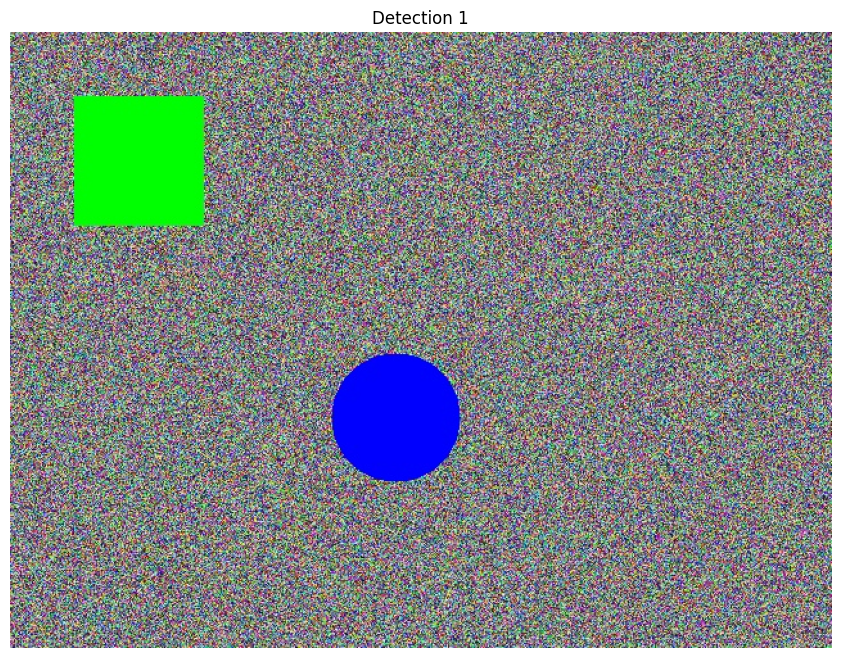

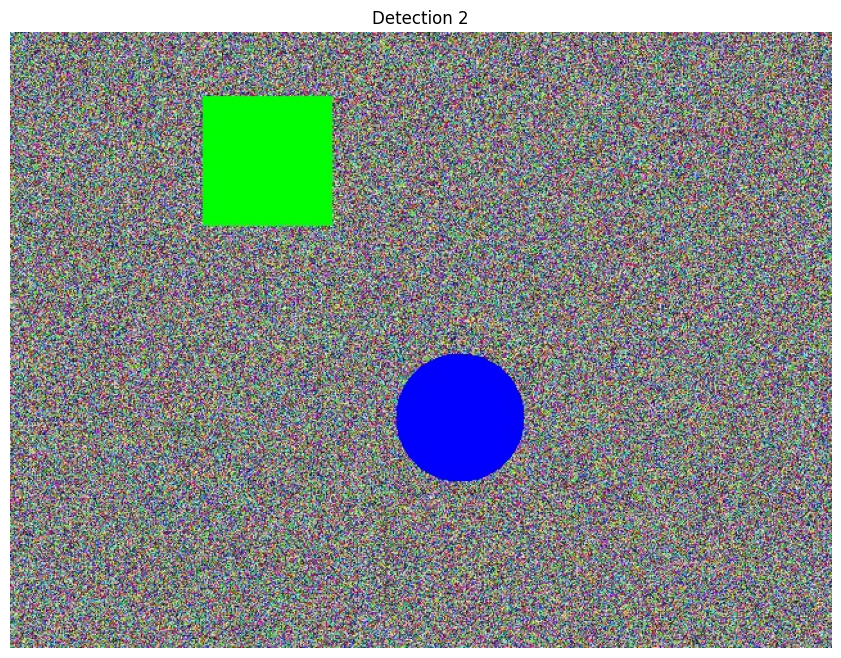

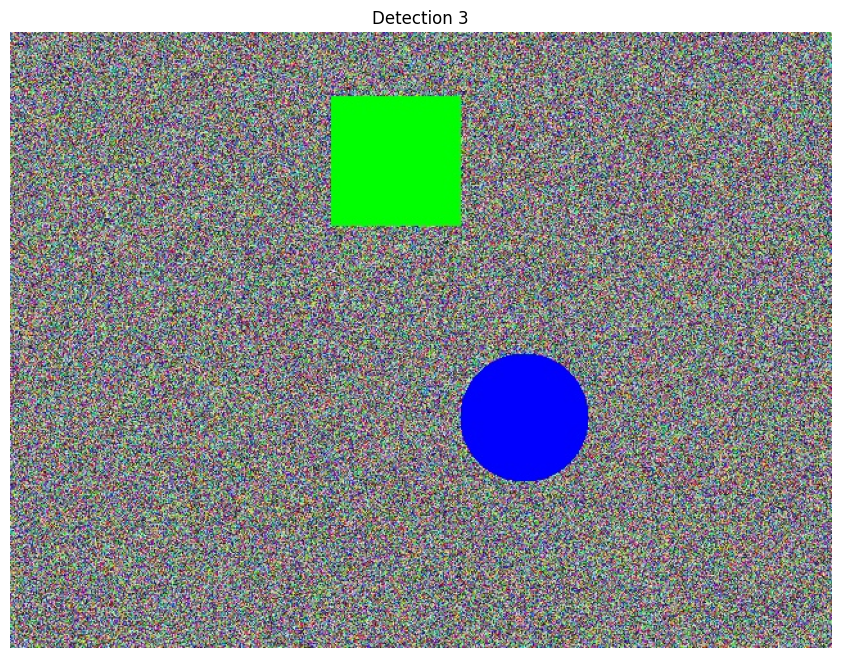


🎯Features:
• Upload & detect: detector.detect_uploaded_image()


In [17]:
detector = main()

Saving @TESTCASEx1.jpg to @TESTCASEx1.jpg

image 1/1 /content/data/@TESTCASEx1.jpg: 384x640 3 cats, 173.5ms
Speed: 3.4ms preprocess, 173.5ms inference, 23.2ms postprocess per image at shape (1, 3, 384, 640)
Results saved to results/detections3


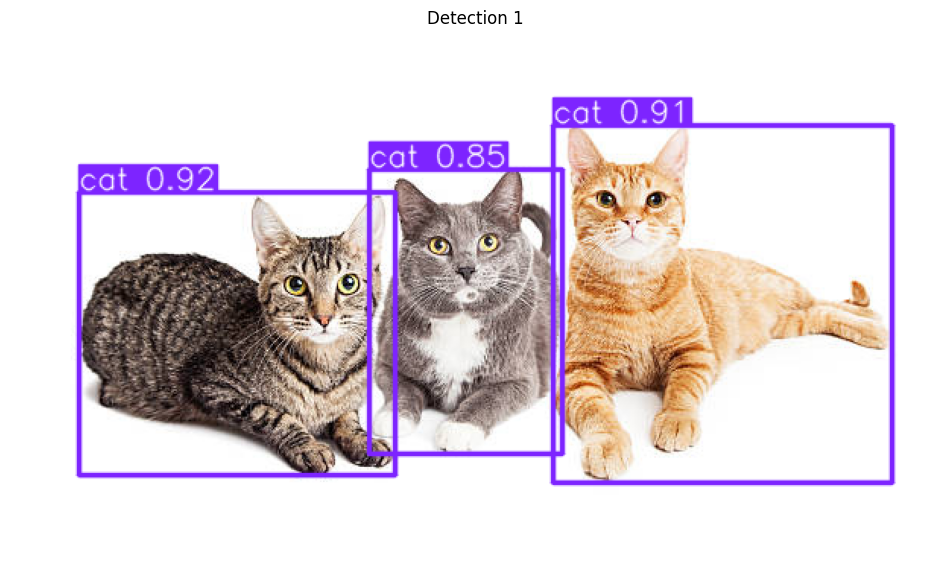

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [18]:
detector.detect_uploaded_image()



image 1/1 /content/data/@TESTCASEx1.jpg: 384x640 3 cats, 161.5ms
Speed: 3.0ms preprocess, 161.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to results/detections4


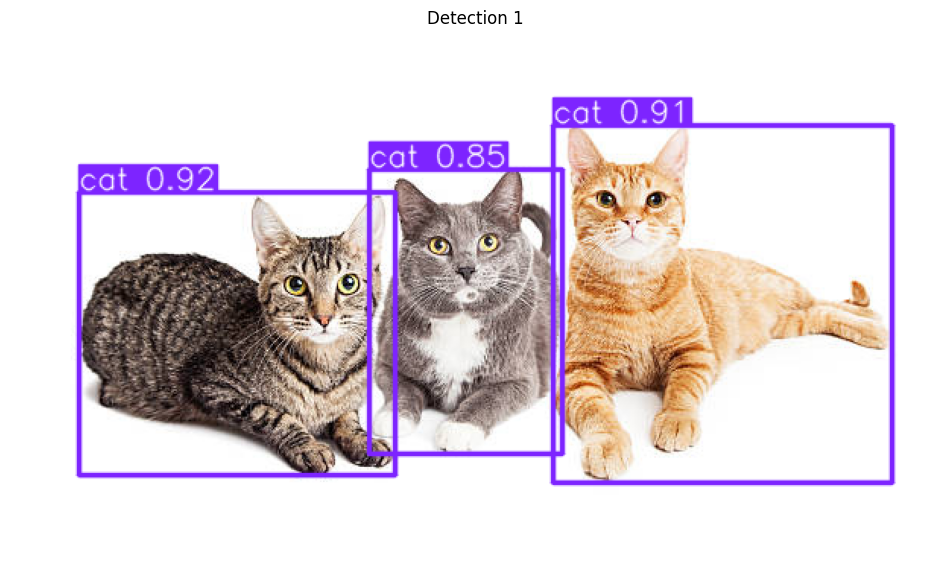

In [21]:
results = detector.detect_objects("/content/data/@TESTCASEx1.jpg", conf_threshold=0.2)
detector.display_results_colab(results)


image 1/1 /content/data/car-967387_1280.webp: 320x640 1 car, 122.6ms
Speed: 2.5ms preprocess, 122.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)
Results saved to results/detections9


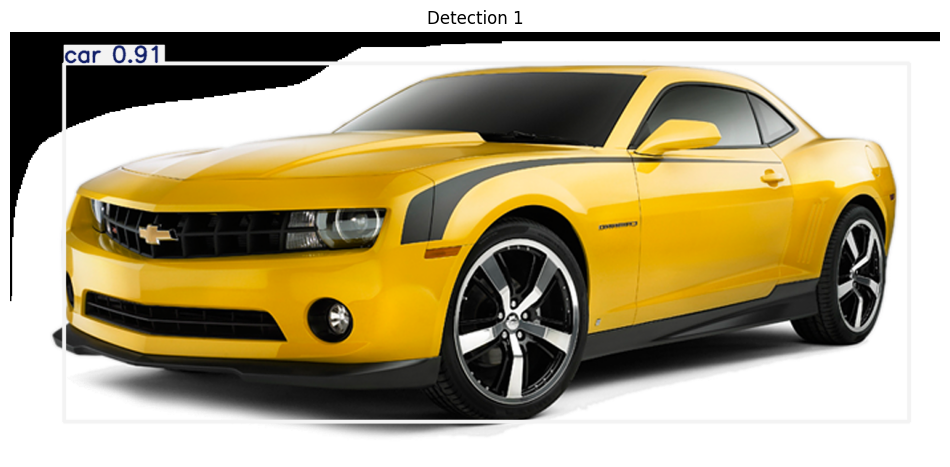

In [28]:
results = detector.detect_objects("/content/data/car-967387_1280.webp", conf_threshold=0.2)
detector.display_results_colab(results)